In [1]:
import parse_data.preprocess as preprocess
import parse_data.loading as loading
import parse_data.flip_rotate_trajectories as flip_rotate_trajectories
from analysis.response_times import calculate_response_times, plot_response_times
import data_extraction.get_indices as get_indices
import globals
from plotting import plot_octagon, plot_trajectory
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Polygon
from matplotlib import colors
import math

In [2]:
# paths
# data_folder = '/home/tom/Documents/SWC/data' # desktop Duan Lab
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-53-34_YansuSecondSolo.json' 
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-31-00_YansuJerrySocial.json'
data_folder = r'D:\Users\Tom\OneDrive\PhD\SWC\data' # desktop home
# json_filename = r'first_experiments_2409\240913\2024-09-13_11-23-37_YansuFirstSolo.json'
json_filename = r'first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json'


In [3]:
# Load JSON file into pandas df with collapsed data dictionary and adjustments based on date of recording 
df = loading.loading_pipeline(data_folder, json_filename)

Data is from period before 2024-09-13 11:31:00
Running dataframe through playerinfo_playerposition_conversion.
Data is from period before 2024-09-13 11:31:00
Running dataframe through remove_zero_wall_numbers
Loading complete.


In [4]:
# Pre-process data 
df = preprocess.standard_preprocessing(df)

Preprocessing complete.


In [5]:
## Extract single trials ##

In [6]:
def split_session_by_trial(df):
    
    # groupby produces an interable of tuples with the group key and the dataframe 
    trials_list = [data for _, data in df.groupby('data.trialNum')]
    
    # exclude trial 0 (could also exclude trial 1)
    trials_list = trials_list[1:]

    # if final  trial does not contain a server selected trigger activation, discard it
    if not globals.SELECTED_TRIGGER_ACTIVATION in trials_list[-1]['eventDescription'].unique():
        trials_list = trials_list[:-1]

    return trials_list


In [7]:
trial_list = split_session_by_trial(df)

In [8]:
## HEATMAPS ##

In [9]:
# generate the location data

# define a grid of counts
n_rows = 6
n_cols = 6
x_min, x_max = -20, 20
y_min, y_max = -20, 20
grid_width = (x_max - x_min)/n_cols
grid_height = (y_max - y_min)/n_rows
grid = np.zeros([n_rows, n_cols])

# # extract starting location of winner for each trial
# trigger_activators_trial_start_loc = get_indices.get_trigger_activators_trial_start_loc(trial_list)
# trigger_activators_trial_start_loc = np.asarray(trigger_activators_trial_start_loc)


# filter trials for a wall separation of 45 degrees
single_wall_sep_trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=1) # verified correct indices
trial_list_single_wall_sep = [trial_list[i] for i in single_wall_sep_trial_indices] # just list comp

# flip and rotate the relevant trials for High and Low to be walls 1 and 2
flip_rotated_single_wall_sep_trials = []
for i in range(len(trial_list_single_wall_sep)):
    flip_rotated_single_wall_sep_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_single_wall_sep, trial_index=i)) 

# get the ID of the player who ended the trial, for each trial
trigger_activators_trial_start_loc = get_indices.get_trigger_activators_trial_start_loc(flip_rotated_single_wall_sep_trials)
trigger_activators_trial_start_loc = np.asarray(trigger_activators_trial_start_loc)



# Create a matrix of heatmap counts based on which bin starting location fits into
for i in range(len(trigger_activators_trial_start_loc[:,0])):
    x_val = trigger_activators_trial_start_loc[i,0]
    y_val = trigger_activators_trial_start_loc[i,1]
    x_bin = int((x_val - x_min)/grid_width)
    y_bin = int((y_val - y_min)/grid_height)

    if 0 <= y_bin < n_rows and 0 <= x_bin < n_cols:
            grid[y_bin, x_bin] += 1


    



In [10]:
x_min = -20
x_max = 20
y_min = -20
y_max = 20

In [11]:
trigger_activators_trial_start_loc.shape

(40, 2)

In [12]:
def heatmap_counts_from_location_data(location_array, n_rows=6, n_cols=6, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max):
    ''' Produce a matrix of counts across spatial location from n-x-2 location data '''

    # define a grid of counts
    grid_width = (x_max - x_min)/n_cols
    grid_height = (y_max - y_min)/n_rows
    grid = np.zeros([n_rows, n_cols])

    # Create a matrix of heatmap counts based on which bin starting location fits into
    for i in range(len(location_array[:,0])):
        x_val = location_array[i,0]
        y_val = location_array[i,1]
        x_bin = int((x_val - x_min)/grid_width)
        y_bin = int((y_val - y_min)/grid_height)

        if 0 <= y_bin < n_rows and 0 <= x_bin < n_cols:
            grid[y_bin, x_bin] += 1

    return grid

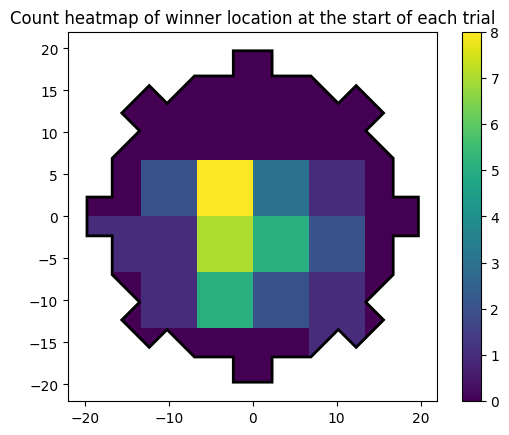

In [13]:
# get the zipped coordinate list of octagon x and y vertex points
octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

# display heatmap, covering the full graph
im = plt.gca().imshow(grid, extent=[x_min, x_max, y_min, y_max],
           origin='upper', cmap='viridis')

# a matplotlib Artist with an edge and face colour
patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)

ax = plt.gca()
ax.add_patch(patch)         # make octagon outline visible
im.set_clip_path(patch)     # crop image to coordinates inside the outline

# Set aspect ratio to be square
ax.set_aspect(1.)

# give some white border to the graph
ax.set_xlim([-22,22])
ax.set_ylim([-22,22])

plt.colorbar(im)



ax.set_title("Count heatmap of winner location at the start of each trial")

# show graph
plt.show()

In [14]:
def plot_heatmap_from_count_array(ax, count_array, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max):

    # get the zipped coordinate list of octagon x and y vertex points
    octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

    # display heatmap, covering the full graph
    im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
               origin='lower', cmap='viridis')
    
    # a matplotlib Artist with an edge and face colour
    patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
    

    ax.add_patch(patch)         # make octagon outline visible
    im.set_clip_path(patch)     # crop image to coordinates inside the outline
    
    # Set aspect ratio to be square
    ax.set_aspect(1.)
    
    plt.colorbar(im)

    ax.set_title("Count heatmap of winner location at the start of each trial")
    
    # give some white border to the graph
    ax.set_xlim([-22,22])
    ax.set_ylim([-22,22])
    
    # # show graph
    # plt.show()

    return ax

In [15]:
octagon_vertex_coordinates

[(6.928483542969951, 16.726838936116845),
 (10.194602007352248, 13.460720471734547),
 (12.31592235091189, 15.582040815294189),
 (15.582040815294189, 12.31592235091189),
 (13.460720471734547, 10.194602007352248),
 (16.726838936116845, 6.928483542969952),
 (16.726838936116845, 2.309494514323318),
 (19.726838936116845, 2.309494514323318),
 (19.726838936116845, -2.3094945143233154),
 (16.726838936116845, -2.3094945143233154),
 (16.726838936116845, -6.92848354296995),
 (13.460720471734547, -10.194602007352248),
 (15.582040815294189, -12.31592235091189),
 (12.31592235091189, -15.582040815294189),
 (10.194602007352248, -13.460720471734547),
 (6.9284835429699525, -16.726838936116845),
 (2.309494514323318, -16.726838936116845),
 (2.309494514323318, -19.726838936116845),
 (-2.3094945143233154, -19.726838936116845),
 (-2.3094945143233154, -16.726838936116845),
 (-6.928483542969949, -16.72683893611685),
 (-10.194602007352247, -13.46072047173455),
 (-12.31592235091189, -15.582040815294192),
 (-15.5

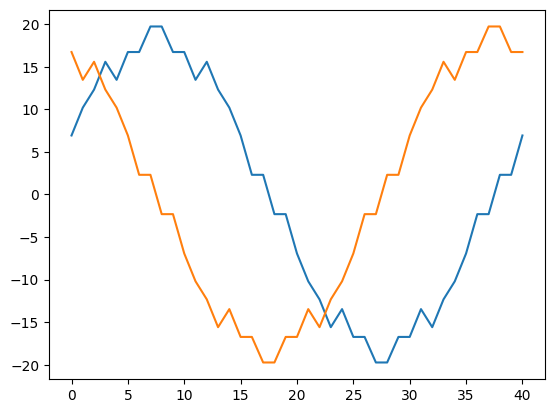

In [16]:
plt.plot(octagon_vertex_coordinates)

In [17]:
x_coords, y_coords = zip(*octagon_vertex_coordinates)

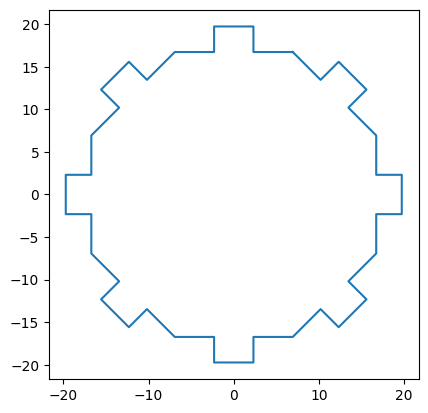

In [18]:
plt.plot(x_coords, y_coords)
plt.gca().set_aspect(1.)

In [19]:
a = [1,2,3,4,5]
a = np.asarray(a)

In [20]:
a[[2,3,4]]

array([3, 4, 5])

In [21]:
trigger_activators_trial_start_loc.shape

(40, 2)

Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation')

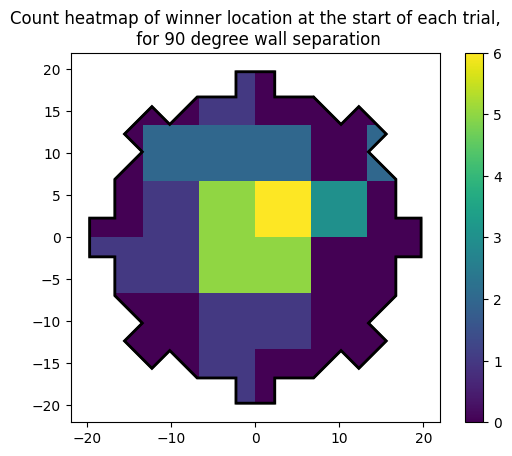

In [22]:
# filter trials for a wall separation of 45 degrees
single_wall_sep_trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=2) # verified correct indices
trial_list_single_wall_sep = [trial_list[i] for i in single_wall_sep_trial_indices] # just list comp

# flip and rotate the relevant trials for High and Low to be walls 1 and 2
flip_rotated_single_wall_sep_trials = []
for i in range(len(trial_list_single_wall_sep)):
    flip_rotated_single_wall_sep_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_single_wall_sep, trial_index=i)) 

# get the ID of the player who ended the trial, for each trial
trigger_activators_trial_start_loc = get_indices.get_trigger_activators_trial_start_loc(flip_rotated_single_wall_sep_trials)
trigger_activators_trial_start_loc = np.asarray(trigger_activators_trial_start_loc)

# generate heat map data and plot
count_array = heatmap_counts_from_location_data(trigger_activators_trial_start_loc)
ax = plot_octagon.plot_octagon()
plot_heatmap_from_count_array(ax, count_array)


ax.set_title("Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation")

Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation')

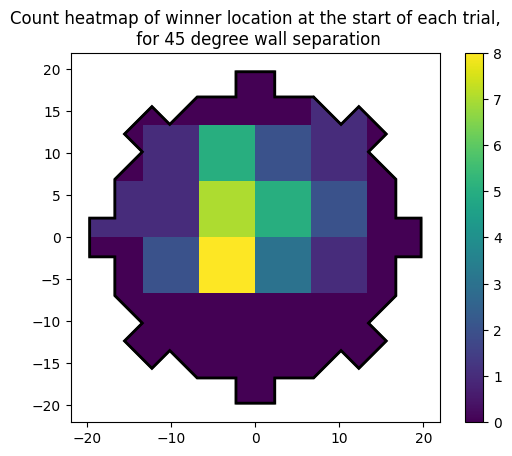

In [23]:
# filter trials for a wall separation of 45 degrees
single_wall_sep_trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=1) # verified correct indices
trial_list_single_wall_sep = [trial_list[i] for i in single_wall_sep_trial_indices] # just list comp

# flip and rotate the relevant trials for High and Low to be walls 1 and 2
flip_rotated_single_wall_sep_trials = []
for i in range(len(trial_list_single_wall_sep)):
    flip_rotated_single_wall_sep_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_single_wall_sep, trial_index=i)) 

# get the ID of the player who ended the trial, for each trial
trigger_activators_trial_start_loc = get_indices.get_trigger_activators_trial_start_loc(flip_rotated_single_wall_sep_trials)
trigger_activators_trial_start_loc = np.asarray(trigger_activators_trial_start_loc)

# generate heat map data and plot
count_array = heatmap_counts_from_location_data(trigger_activators_trial_start_loc)
ax = plot_octagon.plot_octagon()
plot_heatmap_from_count_array(ax, count_array)

ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation")


Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation')

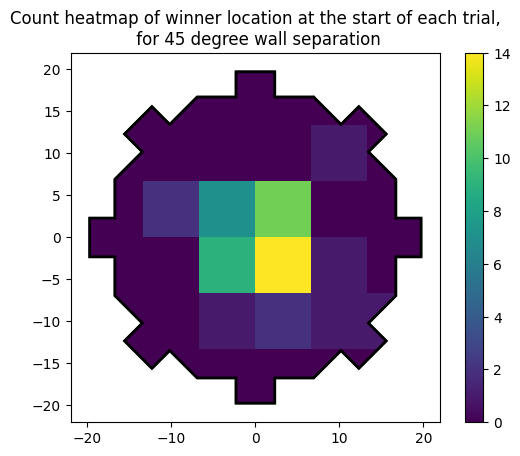

In [24]:
# filter trials for a wall separation of 45 degrees
single_wall_sep_trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=4) # verified correct indices
trial_list_single_wall_sep = [trial_list[i] for i in single_wall_sep_trial_indices] # just list comp

# flip and rotate the relevant trials for High and Low to be walls 1 and 2
flip_rotated_single_wall_sep_trials = []
for i in range(len(trial_list_single_wall_sep)):
    flip_rotated_single_wall_sep_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_single_wall_sep, trial_index=i)) 

# get the ID of the player who ended the trial, for each trial
trigger_activators_trial_start_loc = get_indices.get_trigger_activators_trial_start_loc(flip_rotated_single_wall_sep_trials)
trigger_activators_trial_start_loc = np.asarray(trigger_activators_trial_start_loc)

# generate heat map data and plot
count_array = heatmap_counts_from_location_data(trigger_activators_trial_start_loc)
ax = plot_octagon.plot_octagon()
plot_heatmap_from_count_array(ax, count_array)

ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation")

In [25]:
trigger_activators_trial_start_loc

array([[ -5.5654116 ,  -7.18318197],
       [  2.19123488,   1.16946378],
       [ -3.58556694,  -5.15040861],
       [  0.28717488,   4.84858131],
       [ -3.11953435,  -1.93396854],
       [  0.78788537,   1.59952343],
       [  3.19525087,  -8.33569125],
       [  8.61870548, -12.96865137],
       [ -1.5714227 ,  -2.50397205],
       [ 14.31084538, -11.73732471],
       [ -1.78615883,   5.29404305],
       [  0.55740244,  -3.32161007],
       [  1.8846974 ,  -0.14169172],
       [ -4.28110218,  -4.03837204],
       [  0.36330903,  -3.19962454],
       [  7.06387711,  11.44855118],
       [  3.17955709,  -1.01084948],
       [ -8.2089464 ,   4.2133901 ],
       [  2.72452275,  -4.06622536],
       [  2.02320922,  -5.19900056],
       [  0.17473965,   3.49062678],
       [ -2.01347929,   3.95325882],
       [ -1.83483439,   4.81300016],
       [ -7.81605577,   2.55737495],
       [ -1.77998018,   2.44691372],
       [  1.77815378,  -2.0191772 ],
       [  1.41368236,  -1.93229188],
 

In [26]:
len(flip_rotated_single_wall_sep_trials)

50

In [27]:
count_array

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  2.,  1.,  1.],
       [ 0.,  0.,  9., 14.,  1.,  0.],
       [ 0.,  2.,  7., 11.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])